### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempNNhierALLTheory/'
p1 = 'tempNNhierALLTheory/'

base_path = '../results/'+p1

treated = pd.read_pickle(p+'treated2.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'matched.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 289 ms, sys: 154 ms, total: 443 ms
Wall time: 768 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
treated.MYR.min()

201710

In [6]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [7]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [8]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [9]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [10]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.2 s, sys: 27.3 ms, total: 12.3 s
Wall time: 12.3 s


In [11]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2608221   1  1      0     0.0     0.0        0               81        442   
4  2619378   1  1      0     0.0     0.0        1               78        399   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202010        0.0          1  
4  201910        0.0          1  

[5 rows x 94 columns]

In [12]:
survTr.shape, survCo.shape

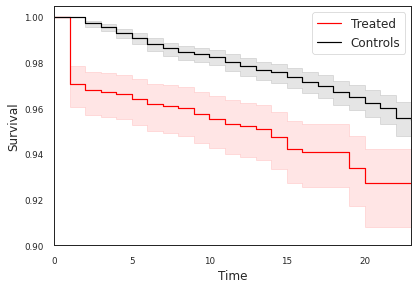

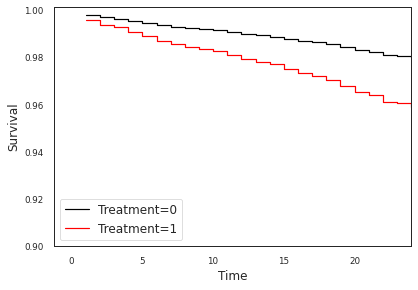

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       30.016048  4.284854e-08  24.476179

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.899           0.417        4.548    0.000
Total Cost                        0.006           0.027        0.217    0.828
Gender                            0.361           0.141        2.557    0.011
Tobacco Use                      -0.104           0.244       -0.428    0.669
Pressure                        -14.150         937.969       -0.015    0.988
Obesity                           0.749           0.144        5.202    0.000
Hypertension                      0.180           0.148        1.214    0.225
Hypothyroid                      -0.112           0.207       -0.543    0.587
Disease Count                     1.759           0.617        2.852    0.004
Acute Care 2 Months               0.925           0.349        2.648    0.008
Acute Care 6 Months              -1.593           0.824       -1.933    0.053
Inpatient Visits 6 Months         0.861           0.644        1.336    0.182
Emergency Vistits 6 Months        1.373           0.761        1.805    0.071
Line of Bussiness                -0.425           0.278       -1.528    0.126
Treatment                         0.732           0.133        5.501    0.000

### ER

data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
treated.columns

Index(['PERS_ID', 'MYR', 'MBR_GNDR', 'AGE_AT_MIDMONTH', 'ALLOW_AMT',
       'MEDICAID_LOB', 'ALLOW_ER', 'ALLOW_IP', 'CC_ADHD', 'CC_ALZHEIMER',
       'CC_ALZHEIMER_PLUS', 'CC_AMI', 'CC_ANEMIA', 'CC_ANXIETY_DISORDER',
       'CC_ARTHRITIS', 'CC_ASTHMA', 'CC_ATRIAL_FIB', 'CC_AUTISM', 'CC_BIPOLAR',
       'CC_BPH', 'CC_BREAST_CANCER', 'CC_CATARACT', 'CC_CEREBRAL_PALSY',
       'CC_CHRONIC_KIDNEY', 'CC_COLORECTAL_CANCER', 'CC_COPD',
       'CC_CYSTIC_FIBROSIS', 'CC_DEPRESSION', 'CC_DEPRESSIVE_DISORDERS',
       'CC_DEVELOP_DELAYS', 'CC_DIABETES', 'CC_DISAB_DX_CNT', 'CC_DX_CNT',
       'CC_ENDOMETRIAL_CANCER', 'CC_EPILEPSY', 'CC_FIBROMYALGIA',
       'CC_GLAUCOMA', 'CC_HEARING_IMPAIR', 'CC_HEART_FAILURE',
       'CC_HEPATITIS_A', 'CC_HEPATITIS_B_ACUTE', 'CC_HEPATITIS_B_CHRONIC',
       'CC_HEPATITIS_C_ACUTE', 'CC_HEPATITIS_C_CHRONIC',
       'CC_HEPATITIS_C_UNSPECIFIED', 'CC_HEPATITIS_D', 'CC_HEPATITIS_E',
       'CC_HEPATITIS_GEN', 'CC_HIP_FRACTURE', 'CC_HYPERLIPIDEMIA',
       'CC_HYPERTE

In [17]:
%%time
onset = 'ER_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, 
                                                 grace = grace, 
                                                 onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset,
                                                  grace = grace).reset_index(drop = True).dropna(axis = 0,subset = ['PERS_ID'])


CPU times: user 12.2 s, sys: 39.4 ms, total: 12.2 s
Wall time: 12.2 s


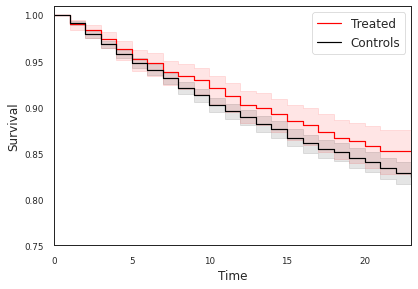

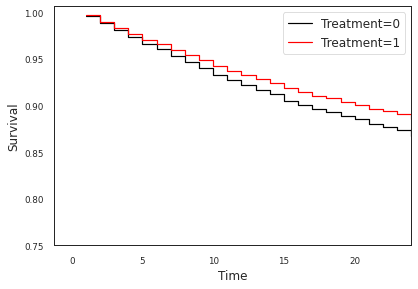

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.75]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [19]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits        2.072131  0.150012  2.736852

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.011           0.203       -4.974    0.000
Total Cost                        0.032           0.014        2.216    0.027
Gender                            0.009           0.084        0.103    0.918
Tobacco Use                       0.073           0.108        0.677    0.498
Pressure                          1.070           0.363        2.948    0.003
Obesity                           0.145           0.069        2.106    0.035
Hypertension                      0.042           0.078        0.543    0.587
Hypothyroid                      -0.266           0.118       -2.246    0.025
Disease Count                     1.277           0.327        3.900    0.000
Acute Care 2 Months               1.121           0.137        8.214    0.000
Acute Care 6 Months              -0.204           0.327       -0.623    0.533
Inpatient Visits 6 Months        -0.231           0.257       -0.896    0.370
Emergency Vistits 6 Months        0.781           0.306        2.553    0.011
Line of Bussiness                -0.497           0.122       -4.090    0.000
Treatment                        -0.157           0.086       -1.818    0.069

### IP

data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.3 s, sys: 73.2 ms, total: 12.4 s
Wall time: 12.4 s


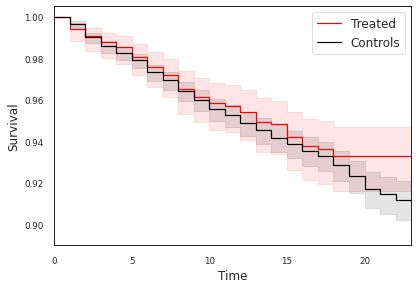

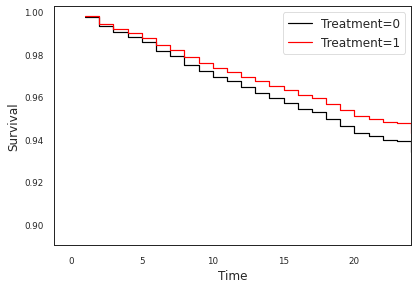

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.89]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [23]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits        0.818164  0.365717  1.451199

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               0.427           0.302        1.415    0.157
Total Cost                        0.169           0.024        6.987    0.000
Gender                            0.078           0.113        0.684    0.494
Tobacco Use                      -0.178           0.161       -1.105    0.269
Pressure                         -1.481           1.008       -1.469    0.142
Obesity                           0.217           0.100        2.174    0.030
Hypertension                     -0.111           0.109       -1.013    0.311
Hypothyroid                      -0.185           0.152       -1.217    0.224
Disease Count                     2.883           0.409        7.055    0.000
Acute Care 2 Months               1.002           0.191        5.239    0.000
Acute Care 6 Months              -0.700           0.354       -1.976    0.048
Inpatient Visits 6 Months         1.114           0.322        3.460    0.001
Emergency Vistits 6 Months        0.486           0.314        1.545    0.122
Line of Bussiness                -0.351           0.183       -1.922    0.055
Treatment                        -0.153           0.123       -1.242    0.214

### Acute Care IP OR ER

data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [25]:
%%time
onset = 'ACUTE'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12.3 s, sys: 43 ms, total: 12.4 s
Wall time: 12.4 s


In [26]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
4     2619378   3  1     0.0     0.0        1               78        399   
5     2621187  11  1     0.0     0.0        2               78      13007   
6     2623521  28  1     0.0     0.0        0               77          0   
16    2651688   4  1     0.0     0.0        0               74        179   
26    2668219   5  1     0.0     0.0        0               71        346   
...       ...  .. ..     ...     ...      ...              ...        ...   
1330  4390059   4  1     0.0     0.0        0               47          2   
1334  4398341  11  1     0.0     0.0        0               66          0   
1337  5001236  16  1     0.0     0.0        0               60        374   
1342  5003200   1  1     1.0     1.0        1               55       3137   
1348  5014675   3  1     0.0     0.0        1               26        409   

      ALLOW_ER  ALLOW_IP  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4          0.0       0.0  ...       0      0.0      0.0     0    1         1   
5          0.0       0.0  ...       0      0.0      0.0     0    1         1   
6          0.0       0.0  ...       0      0.0      0.0     0    1         0   
16         0.0       0.0  ...       0      0.0      0.0     0    1         1   
26         0.0       0.0  ...       0      0.0      0.0     0    1         0   
...        ...       ...  ...     ...      ...      ...   ...  ...       ...   
1330       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1334       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1337       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1342    1298.0       0.0  ...       0      0.0      0.0     0    1         0   
1348       0.0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
26        Medicare  201911        0.0          1  
...            ...     ...        ...        ...  
1330    Commercial  202002        0.0          1  
1334      Medicare  202005        0.0          1  
1337    Commercial  202002        0.0          1  
1342    Commercial  202005        0.0          1  
1348    Commercial  202010        0.0          1  

[212 rows x 94 columns]

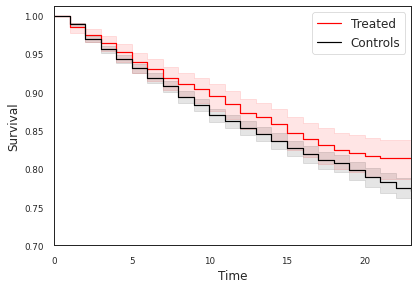

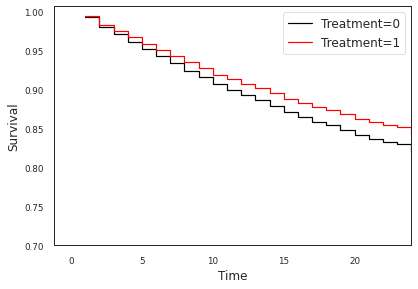

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [28]:
lrsumm

test_statistic         p  -log2(p)
Acute Care        2.647417  0.103718  3.269258

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.576           0.179       -3.225    0.001
Total Cost                        0.068           0.013        5.277    0.000
Gender                            0.018           0.072        0.250    0.802
Tobacco Use                       0.002           0.096        0.025    0.980
Pressure                          0.541           0.361        1.497    0.134
Obesity                           0.174           0.060        2.892    0.004
Hypertension                     -0.009           0.068       -0.138    0.890
Hypothyroid                      -0.216           0.099       -2.184    0.029
Disease Count                     1.629           0.285        5.705    0.000
Acute Care 2 Months               1.189           0.121        9.824    0.000
Acute Care 6 Months               0.215           0.272        0.791    0.429
Inpatient Visits 6 Months        -0.178           0.242       -0.736    0.462
Emergency Vistits 6 Months        0.192           0.255        0.755    0.450
Line of Bussiness                -0.519           0.108       -4.816    0.000
Treatment                        -0.154           0.075       -2.044    0.041

### Acute Care  diff and diff calculation

In [30]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls_all = pd.read_pickle(p+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 12 s, sys: 14.4 s, total: 26.4 s
Wall time: 27.1 s


In [31]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), controls_all.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

try:
    controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    controls2 = controls2
try:
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    treated2 = treated2
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
#for d in data2:
#    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 27.2 s, sys: 2.3 s, total: 29.5 s
Wall time: 29.5 s


In [32]:
treated2.shape, controls2.shape

In [33]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [34]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [35]:
%%time
times = [0]
onset = 'ACUTE'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.4 s, sys: 110 ms, total: 12.5 s
Wall time: 12.5 s


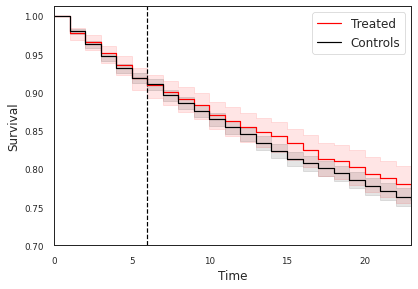

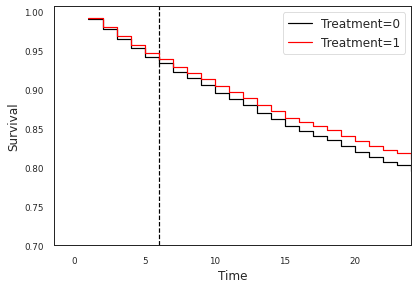

In [36]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [37]:
lrsummDD

test_statistic         p  -log2(p)
Acute Care_dd        1.885648  0.169694  2.558996

In [38]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.482           0.149       -3.226    0.001
Total Cost                        0.058           0.010        5.799    0.000
Gender                            0.170           0.061        2.801    0.005
Tobacco Use                       0.141           0.083        1.687    0.092
Pressure                          0.227           0.342        0.665    0.506
Obesity                          -0.003           0.052       -0.058    0.954
Hypertension                     -0.123           0.061       -2.011    0.044
Hypothyroid                      -0.015           0.084       -0.177    0.859
Disease Count                     1.627           0.240        6.789    0.000
Acute Care 2 Months               1.160           0.105       11.052    0.000
Acute Care 6 Months               0.568           0.266        2.134    0.033
Inpatient Visits 6 Months        -0.200           0.231       -0.865    0.387
Emergency Vistits 6 Months       -0.113           0.256       -0.443    0.658
Line of Bussiness                -0.535           0.092       -5.829    0.000
Treatment                        -0.087           0.065       -1.333    0.183

### Load all Log Rank Sums in a matrix

In [39]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [40]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      30.02                  0.00   
Emergency Visits               2.07                  0.15   
Inpatient Vistis               0.82                  0.37   
Acute Care                     2.65                  0.10   
Acute Care DD                  1.89                  0.17   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.14   
Emergency Visits                            0.02   
Inpatient Vistis                            0.00   
Acute Care                                  0.03   
Acute Care DD                               0.01   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.30   
Emergency Visits                             0.10   
Inpatient Vistis                             0.02   
Acute Care                                   0.14   
Acute Care DD                                0.04   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.47   
Emergency Visits                             0.20   
Inpatient Vistis                             0.04   
Acute Care                                   0.26   
Acute Care DD                                0.13   

                  RMST Difference After 24 Months  
Diabetes                                    -0.65  
Emergency Visits                             0.32  
Inpatient Vistis                             0.14  
Acute Care                                   0.44  
Acute Care DD                                0.23